### Reference materials

Z-score is used when calculating CI knowing populations variance.
T-score is used when calculating CI not knowing populations variance (lower than 30 samples). 

Cumulative Distribution Function - distribution function of X, evaluated at x, is the probability that 
X will take a value less than or equal to x

For samples of population an Empirical Cumulative Distribution Function can be used with confidence intervals from Dvoretzky-Kiefer-Wolfowitz (DKW) inequality.


https://www.westga.edu/academics/research/vrc/assets/docs/confidence_intervals_notes.pdf

https://www.jmp.com/en_us/statistics-knowledge-portal/t-test/t-distribution.html

https://james-brennan.github.io/posts/edf/

https://en.wikipedia.org/wiki/Dvoretzky–Kiefer–Wolfowitz_inequality


### Imports

In [1]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sci_analysis import analyze
from statsmodels.distributions.empirical_distribution import ECDF
# %matplotlib inline


### Constants and variables

In [2]:
SEED = 42
RESET_SEED = True
np.random.seed(SEED)

# VARIABLES ----------------------------------------
DATA_DIR = '../data/ComCom_Adam/'
DATA_TEST_DIR = '../data/ComCom_Adam/scaler_000/'
DATA_TEST_FILE_PREFIX = '000_'
# setup time files
TIMES = [15, 60, 120, 180, 240, 360, 480, 720, 1440]
# model: before|after
MODELS = ['after', 'before']
# bins
TRAFFIC_BINS = [(i + 1) * 500 for i in range(20)]
# how much overhead to meet required confidence based on eCDF
CONFIDENCE = [0.9, 0.95, 0.97]


# CONSTANTS ----------------------------------------
DATA_REAL_NAME = 'real'
DATA_BEFORE_NAME = 'before'
DATA_AFTER_NAME = 'after'


### Functions

In [3]:
def init_random():
    np.random.seed(SEED)
    

def perc_underestimated_traffic(df_real, df_pred):
    under_recs = ((df_pred - df_real) < 0).astype(int).sum().sum()
    all_recs = df_pred.size
    return under_recs / all_recs * 100


def get_distributions(df, bins=1000, alpha=0.05, plot=True):
    '''
    get pdf, cdf and ecdf
    
    returns pdf, cdf, ecdf, ecdf_lower, ecdf_upper, bins
    '''

    pdf, bins = np.histogram(df, bins=bins)

    # cumulative distribution normalized to 0:1
    cdf = np.cumsum(pdf.data)
    cdf = cdf / cdf[-1] 
    
    # calculating ecdf and its lower/upper bounds
    _ecdf = ECDF(df)
    ecdf = np.array([_ecdf.y, _ecdf.x])
    
    # Dvoretzky–Kiefer–Wolfowitz confidence bounds
    epsilon = np.sqrt(1/(2*len(ecdf[1])) * np.log(2./alpha))
    ecdf_upper = np.minimum(ecdf[0] + epsilon, 1)
    ecdf_lower = np.maximum(ecdf[0] - epsilon, 0)
    
    if plot:
        fig, ax = plt.subplots(1, 3, figsize=(8, 3))
        _ = ax[0].hist(bins[:-1], bins, weights=pdf)
        _ = ax[0].set_title("PDF")
        
        _ = ax[1].hist(bins[:-1], bins, weights=cdf)
        _ = ax[1].set_title("CDF")
        
        _ = ax[2].plot(ecdf[1], ecdf[0], '-')
        _ = ax[2].fill_between(ecdf[1], ecdf_upper, ecdf_lower, color='y')
        _ = ax[2].set_title("eCDF")
        sns.despine()

    return np.array([pdf, bins[:-1]]), np.array([cdf, bins[:-1]]), \
           ecdf, np.array([ecdf_lower, _ecdf.x]), np.array([ecdf_upper, _ecdf.x]), bins


def get_x_for_y(yx_data, y):
    '''
        Find x value matching given y value using linear approximation
        
        return: x, y, x_l, x_r, y_l, y_r
    '''
    
    # finding first index above condition
    idx = np.where(yx_data[0] >= y)  

    idx = idx[0][0] if len(idx[0]) > 0 else len(yx_data[0]) - 1
    x_r = yx_data[1][idx]
    y_r = yx_data[0][idx]
    
    if idx > 0:
        x_l = yx_data[1][idx - 1]
        y_l = yx_data[0][idx - 1]
        # from line segment: (1 - lambd) y_l + lambd * y_r = y
        lambd = (y - y_l) / (y_r - y_l) 
        x = (1 - lambd) * x_l + lambd * x_r
    else:
        x = x_r
        x_l = x_r
        y_l = y
        
    return x, y, x_l, x_r, y_l, y_r

# Execution

In [4]:
# load files

dfs_real = []
dfs_pred = []

dfs_real_test = []
dfs_pred_test = []

for model in MODELS:
    # train data
    dfs_real_inner = []
    dfs_pred_inner = []
    for time in TIMES:
        dfs_real_inner.append(pd.read_csv(DATA_DIR + DATA_REAL_NAME + str(time) + '.csv', sep='\t', header=None))
        if model == 'after':
            dfs_pred_inner.append(pd.read_csv(DATA_DIR + DATA_AFTER_NAME + str(time) + '.csv', sep='\t', header=None))
        elif model == 'before':
            dfs_pred_inner.append(pd.read_csv(DATA_DIR + DATA_BEFORE_NAME + str(time) + '.csv', sep='\t', header=None))
    dfs_real.append(dfs_real_inner)
    dfs_pred.append(dfs_pred_inner)
    
    # test data
    dfs_real_test_inner = []
    dfs_pred_test_inner = []
    for time in TIMES:
        dfs_real_test_inner.append(pd.read_csv(DATA_TEST_DIR + DATA_TEST_FILE_PREFIX + DATA_REAL_NAME + str(time) + '.csv', sep='\t', header=None))
        if model == 'after':
            dfs_pred_test_inner.append(pd.read_csv(DATA_TEST_DIR + DATA_TEST_FILE_PREFIX + DATA_AFTER_NAME + str(time) + '.csv', sep='\t', header=None))
        elif model == 'before':
            dfs_pred_test_inner.append(pd.read_csv(DATA_TEST_DIR + DATA_TEST_FILE_PREFIX + DATA_BEFORE_NAME + str(time) + '.csv', sep='\t', header=None))
    dfs_real_test.append(dfs_real_test_inner)
    dfs_pred_test.append(dfs_pred_test_inner)
        
    

## Case 1: Treat all values from models for various node pairs as single distribution

In [5]:
# result describing how much add abs_value or percentage for given period/model having confidence that <conf>
# predictions are not underestimated

# abs_value - how much add absolute value
# abs_wo_approx - linear approximation may go outside the right boundary
# percentage - homu much percenta add to value 
# percentage_wo_appox - linear approximation may go outside the right boundary

col_names = ['model', 'period', 'conf', 'abs_value', 'abs_wo_approx', 'percentage', 'percentage_wo_approx']
df_result = pd.DataFrame(columns=col_names)

for m_idx, model in enumerate(MODELS):
    for t_idx, time in enumerate(TIMES):
        
        real = dfs_real[m_idx][t_idx]
        pred = dfs_pred[m_idx][t_idx]
    
        real_stk = real.stack().reset_index(drop=True)
        pred_stk = pred.stack().reset_index(drop=True)
        diff = (real_stk - pred_stk)
        perc = (real_stk - pred_stk) / pred_stk * 100 
#         perc_half = perc[perc > 0].reset_index(drop=True)
        
        pdf, cdf, ecdf, ecdf_lower, ecdf_upper, bins = get_distributions(df=diff, plot=False)

        res = [{'model' : model, 'period' : time, 'conf': conf} for conf in CONFIDENCE]
        
        for conf_idx, conf in enumerate(CONFIDENCE):
            x, y, x_l, x_r, *_ = get_x_for_y(yx_data=ecdf_lower, y=conf) 
            res_d = res[conf_idx]
            res_d['abs_value'] = x 
            res_d['abs_wo_approx'] = x_r
                
        
        pdf, cdf, ecdf, ecdf_lower, ecdf_upper, bins = get_distributions(df=perc, plot=False)
            
        for conf_idx, conf in enumerate(CONFIDENCE):
            x, y, x_l, x_r, *_ = get_x_for_y(yx_data=ecdf_lower, y=conf) 
            res_d = res[conf_idx]
            res_d['percentage'] = x
            res_d['percentage_wo_approx'] = x_r
            
        df_result = pd.concat([df_result, pd.DataFrame(data=res, columns=col_names)], axis=0, ignore_index=True)
        
df_result = df_result.reset_index(drop=True)

In [6]:
display(df_result)

,model,period,conf,abs_value,abs_wo_approx,percentage,percentage_wo_approx
0,after,15,0.90,176.000000,176.000000,16.427288,16.427784
1,after,15,0.95,230.000000,230.000000,21.073646,21.074816
2,after,15,0.97,275.000000,275.000000,24.675325,24.675325
3,after,60,0.90,202.000000,202.000000,18.133728,18.134715
4,after,60,0.95,261.000000,261.000000,22.727273,22.727273
5,after,60,0.97,311.000000,311.000000,26.241349,26.251277
6,after,120,0.90,216.000000,216.000000,18.954059,18.957346
7,after,120,0.95,274.000000,274.000000,23.544726,23.549884
8,after,120,0.97,329.188030,330.000000,27.658946,27.698574
9,after,180,0.90,233.809315,234.000000,19.111305,19.112628


### Validate

In [7]:
col_names = ['model', 'period', 'conf', 'underestimate', 'corr_abs', 'corr_perc', 'abs_success', 'perc_success']

df_validate_train = pd.DataFrame(columns=col_names)
df_validate_test = pd.DataFrame(columns=col_names)

for m_idx, model in enumerate(MODELS):
    for t_idx, time in enumerate(TIMES):
        train_real = dfs_real[m_idx][t_idx]
        train_pred = dfs_pred[m_idx][t_idx]
        
        test_real = dfs_real_test[m_idx][t_idx]
        test_pred = dfs_pred_test[m_idx][t_idx]
        
        for conf in CONFIDENCE:
            
            sel = df_result[(df_result['model'] == model) & (df_result['period'] == time)  & (df_result['conf'] == conf)]
            
            abs_ov = sel['abs_wo_approx'].values[0]
            perc_ov = sel['percentage_wo_approx'].values[0] / 100
            
            # validate train 
            
            train_pred_abs_ov = train_pred + abs_ov 
            train_pred_perc_ov = train_pred + train_pred * perc_ov
            
            p = perc_underestimated_traffic(df_real=train_real, df_pred=train_pred)
            p_abs = perc_underestimated_traffic(df_real=train_real, df_pred=train_pred_abs_ov)
            p_perc = perc_underestimated_traffic(df_real=train_real, df_pred=train_pred_perc_ov)
            
            abs_success = (1 - conf) * 100 >= p_abs
            perc_success = (1 - conf) * 100 >= p_perc
            
            res = {'model' : model, 
                   'period' : time, 
                   'conf': conf,
                   'underestimate': p,
                   'corr_abs': p_abs,
                   'corr_perc': p_perc,
                   'abs_success': abs_success, 
                   'perc_success': perc_success,
                  } 
            df_validate_train = pd.concat([df_validate_train, pd.DataFrame(res, index=[0])], axis=0, ignore_index=True)

            # validate test
            test_pred_abs_ov = test_pred + abs_ov 
            test_pred_perc_ov = test_pred + train_pred * perc_ov
            
            p = perc_underestimated_traffic(df_real=test_real, df_pred=test_pred)
            p_abs = perc_underestimated_traffic(df_real=test_real, df_pred=test_pred_abs_ov)
            p_perc = perc_underestimated_traffic(df_real=test_real, df_pred=test_pred_perc_ov)
            
            abs_success = (1 - conf) * 100 >= p_abs
            perc_success = (1 - conf) * 100 >= p_perc
            
            res = {'model' : model, 
                   'period' : time, 
                   'conf': conf,
                   'underestimate': p,
                   'corr_abs': p_abs,
                   'corr_perc': p_perc,
                   'abs_success': abs_success, 
                   'perc_success': perc_success,
                  } 
            df_validate_test = pd.concat([df_validate_test, pd.DataFrame(res, index=[0])], axis=0, ignore_index=True)

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display("train table")
    display(df_validate_train)
    display("test table")
    display(df_validate_test)

'train table'

,model,period,conf,underestimate,corr_abs,corr_perc,abs_success,perc_success
0,after,15,0.90,64.575066,9.408069,9.494874,True,True
1,after,15,0.95,64.575066,4.484954,4.494599,True,True
2,after,15,0.97,64.575066,2.473269,2.495315,True,True
3,after,60,0.90,79.144621,8.956129,8.989198,True,True
4,after,60,0.95,79.144621,3.990300,3.979277,True,True
5,after,60,0.97,79.144621,1.978616,1.989638,True,True
6,after,120,0.90,85.339506,8.509700,8.564815,True,True
7,after,120,0.95,85.339506,3.505291,3.571429,True,True
8,after,120,0.97,85.339506,1.521164,1.565256,True,True
9,after,180,0.90,89.203042,8.167989,8.250661,True,True


'test table'

,model,period,conf,underestimate,corr_abs,corr_perc,abs_success,perc_success
0,after,15,0.90,64.581955,12.967097,10.187941,False,False
1,after,15,0.95,64.581955,6.989914,4.544202,False,True
2,after,15,0.97,64.581955,4.263117,2.346506,False,True
3,after,60,0.90,77.645503,12.874780,9.865520,False,True
4,after,60,0.95,77.645503,6.492504,3.973765,False,True
5,after,60,0.97,77.645503,3.692681,1.984127,False,True
6,after,120,0.90,84.380511,13.436949,9.788360,False,True
7,after,120,0.95,84.380511,6.856261,3.968254,False,True
8,after,120,0.97,84.380511,3.769841,1.642416,False,True
9,after,180,0.90,84.672619,11.904762,9.871032,False,True


In [9]:
train_count = df_validate_train['abs_success'].shape[0]
train_abs_suc = df_validate_train['abs_success'].astype(int).sum()    
train_perc_suc = df_validate_train['perc_success'].astype(int).sum()    

test_count = df_validate_test['abs_success'].shape[0]
test_abs_suc = df_validate_test['abs_success'].astype(int).sum()    
test_perc_suc = df_validate_test['perc_success'].astype(int).sum()    

display('train abs: ' + str(train_abs_suc) + "/" + str(train_count) + " -> " + str(train_abs_suc / train_count * 100))
display('train perc: ' + str(train_perc_suc) + "/" + str(train_count) + " -> " + str(train_perc_suc / train_count * 100))
display('test abs: ' + str(test_abs_suc) + "/" + str(test_count) + " -> " + str(test_abs_suc / test_count * 100))
display('test perc: ' + str(test_perc_suc) + "/" + str(test_count) + " -> " + str(test_perc_suc / test_count * 100))

'train abs: 54/54 -> 100.0'

'train perc: 54/54 -> 100.0'

'test abs: 26/54 -> 48.148148148148145'

'test perc: 47/54 -> 87.03703703703704'

# Explore

In [10]:
real = dfs_real[0][0]
pred = dfs_pred[0][0]
df = real[0].shape[0] - 1

In [11]:
real_stk = real.stack().reset_index(drop=True)
pred_stk = pred.stack().reset_index(drop=True)

In [12]:
# real.describe()
# pred.describe()

# because checking underestimation, so underestimation is with positive sign - how much add to meet real traffic
display((real - pred).describe())
display(((real - pred) / pred * 100).describe())
display("diff: " + str((real - pred).iloc[0][1]))
display("perc: " + str(((real - pred) / pred * 100).iloc[0][1]))
display("pred: " + str(pred.iloc[0][1]))
display("real: " + str(real.iloc[0][1]))
display("pred multi by perc: " + str(pred.iloc[0][1]* (1 + ((real - pred) / pred).iloc[0][1])))

,0,1,2,3,4,5,6,7,8,9,...,746,747,748,749,750,751,752,753,754,755
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.00000,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,7.833333,48.406250,-11.614583,20.531250,61.708333,-2.531250,57.520833,33.916667,38.854167,39.06250,...,52.406250,26.812500,27.000000,46.375000,25.083333,43.864583,46.729167,59.510417,28.437500,36.645833
std,208.803089,127.432754,205.777978,140.503302,114.343979,115.037106,110.733438,124.125036,95.133920,97.37673,...,77.902041,70.291171,85.734965,94.492133,83.702439,84.763028,96.727450,100.723488,206.649045,208.641671
min,-471.000000,-223.000000,-542.000000,-258.000000,-159.000000,-241.000000,-227.000000,-272.000000,-182.000000,-190.00000,...,-148.000000,-168.000000,-178.000000,-141.000000,-123.000000,-116.000000,-130.000000,-265.000000,-361.000000,-502.000000
25%,-146.750000,-40.250000,-127.000000,-70.250000,-8.750000,-86.500000,-23.250000,-31.250000,-22.750000,-25.75000,...,-3.250000,-15.500000,-27.250000,-26.000000,-39.000000,-13.250000,-9.500000,-10.500000,-111.500000,-104.500000
50%,17.000000,33.500000,-8.000000,11.000000,55.000000,11.000000,67.500000,32.000000,39.500000,33.50000,...,59.500000,27.500000,30.000000,58.000000,10.000000,30.500000,31.500000,66.500000,-4.500000,11.000000
75%,121.250000,146.750000,94.500000,112.000000,130.000000,70.750000,111.250000,102.500000,95.500000,90.25000,...,102.250000,74.500000,79.000000,107.750000,85.250000,107.250000,98.500000,127.250000,133.500000,192.500000
max,740.000000,412.000000,483.000000,384.000000,366.000000,320.000000,308.000000,410.000000,251.000000,374.00000,...,274.000000,182.000000,234.000000,257.000000,336.000000,286.000000,339.000000,312.000000,639.000000,558.000000


,0,1,2,3,4,5,6,7,8,9,...,746,747,748,749,750,751,752,753,754,755
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.164989,2.081364,-0.771543,1.109558,4.601174,0.454001,3.213434,2.642764,3.836044,3.619775,...,6.759688,4.220755,3.919920,5.406842,4.225295,4.423755,3.782884,4.447346,0.391521,1.002066
std,5.543954,5.830313,6.072756,8.326261,8.169526,7.873382,6.305477,8.577437,8.611523,8.549956,...,10.931962,10.272947,11.061655,11.079574,12.934642,9.080547,8.300721,7.486682,5.106921,4.830993
min,-14.272727,-11.878631,-16.985271,-19.457014,-12.329864,-12.846482,-11.589983,-21.813031,-17.500000,-15.031646,...,-25.127334,-22.489960,-20.296465,-14.920635,-19.617225,-15.611814,-12.776660,-12.722036,-10.538373,-10.581788
25%,-4.126126,-1.808994,-4.027280,-4.391469,-0.592553,-5.879054,-1.556858,-1.869851,-2.127627,-2.077519,...,-0.512716,-2.643641,-3.303627,-3.636362,-5.736506,-1.385888,-0.916491,-0.835399,-3.298473,-2.365662
50%,0.694198,1.600972,-0.222564,0.781674,5.118597,0.666501,3.841665,2.368506,3.895382,2.744821,...,7.227119,4.257435,3.629562,6.303056,1.362401,3.586410,2.834194,3.678820,-0.205362,0.229232
75%,3.881594,5.725322,2.671747,6.689973,9.257962,4.421972,7.460561,8.256749,10.529727,8.828013,...,13.808376,10.983153,10.514548,12.323997,13.546182,11.241608,7.277927,9.763401,3.566409,4.857821
max,16.213848,19.720187,12.379562,19.108911,30.955260,32.193159,16.276124,25.059382,20.535714,27.744807,...,36.291391,29.545455,40.206186,31.544503,52.093023,35.483871,24.726477,33.876221,14.778804,16.484517


'diff: 134'

'perc: 5.259026687598116'

'pred: 2548'

'real: 2682'

'pred multi by perc: 2682.0'

141.0


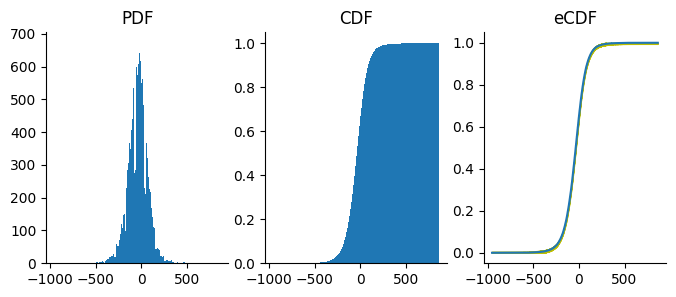

In [13]:
diff_stk = pred_stk - real_stk
diff_stk_norm = st.zscore(diff_stk)

pdf, cdf, ecdf, ecdf_lower, ecdf_upper, bins = get_distributions(df=diff_stk, plot=True)

x, y, x_l, x_r, *_ = get_x_for_y(yx_data=ecdf_lower, y=0.95)
print(x)


23.93254408715129


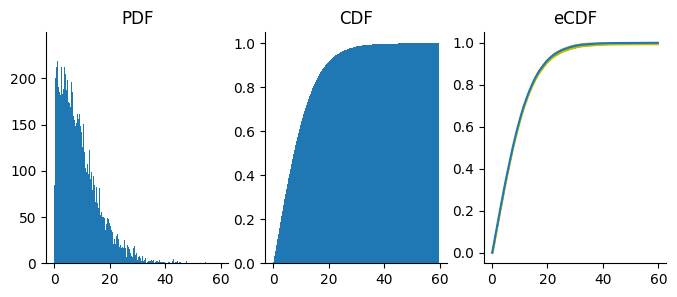

In [14]:
# divide by pred to know how much increase pred to reach real
# i.e. pred + pred * perc = real
# underestimation is with positive sign (how much perc add to meet the real traffic)

perc_stk = (real_stk - pred_stk) / pred_stk * 100
perc_stk_half = perc_stk[perc_stk > 0].reset_index(drop=True)

pdf, cdf, ecdf, ecdf_lower, ecdf_upper, bins = get_distributions(df=perc_stk_half, plot=True)

x, y, x_l, x_r, *_ = get_x_for_y(yx_data=ecdf_lower, y=0.95)
print(x)


In [15]:
if RESET_SEED: init_random();
res = st.kstest(diff_stk_norm.sample(n=500), 'norm')
res.pvalue

0.18407033449881316

In [16]:
if RESET_SEED: init_random();
res = st.shapiro(diff_stk_norm.sample(n=50))
print(res.pvalue)

0.26986634731292725


In [17]:
# get stats

print('mean: ' + str(diff_stk.mean()))
print('std: ' + str(diff_stk.std()))

se = diff_stk.std() / math.sqrt(len(diff_stk)) # standard error st.sem(diff_stk)
print('se: ' + str(se))

t_interval = st.t.interval(confidence=0.95, df=len(diff_stk) - 1, loc=diff_stk.mean(), scale=se)
norm_interval = st.norm.interval(confidence=0.95, loc=diff_stk.mean(), scale=se)

print('t_interval: ' + str(t_interval))
print('norm_interval: ' + str(norm_interval))

mean: -38.78171847442681
std: 113.11031625933246
se: 0.4198611610635595
t_interval: (-39.60464495291593, -37.95879199593769)
norm_interval: (-39.60463122861856, -37.95880572023506)


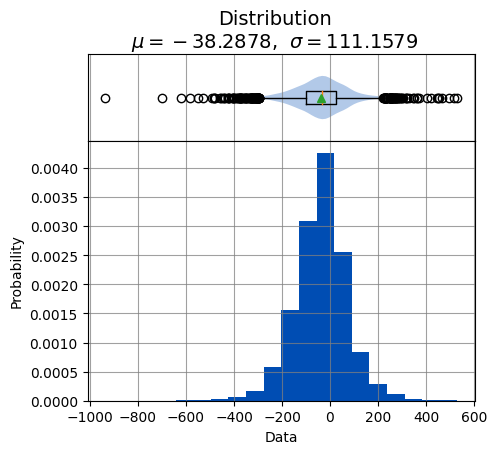



Statistics
----------

n         =  5000
Mean      = -38.2878
Std Dev   =  111.1579
Std Error =  1.5720
Skewness  = -0.2116
Kurtosis  =  2.8036
Maximum   =  531.0000
75%       =  27.0000
50%       = -35.0000
25%       = -101.0000
Minimum   = -937.0000
IQR       =  128.0000
Range     =  1468.0000


Shapiro-Wilk test for normality
-------------------------------

alpha   =  0.0500
W value =  0.9769
p value =  0.0000

HA: Data is not normally distributed



In [18]:
if RESET_SEED: init_random();
analyze(xdata=diff_stk.sample(n=5000))